In [1]:
# make quantum circuit
import qiskit as qk

# Create three quantum and classical registers
q = qk.QuantumRegister(3)
c = qk.ClassicalRegister(3)
qc = qk.QuantumCircuit(q, c)

# Prepare an initial state for qubit ① using a single unitary
qc.u1(.5, q[0])
# Prepare an entangled pair using qubit ② and qubit ③
qc.h(q[1])
qc.cx(q[1], q[2])
# Barrier to prevent gate reordering for optimization
qc.barrier(q)

# Perform a CNOT between qubit ① and qubit ②
qc.cx(q[0], q[1])
# Measure qubit ② in the computational basis
qc.measure(q[1], c[1])
# If needed perform a bit flip correction to qubit ③
if c[1] == 1:
    qc.x(q[2])

# Measure qubit ① in the + - basis
qc.h(q[0])
qc.measure(q[0], c[0])
# If needed perform a phase correction to qubit ③
if c[0] == 1:
    qc.z(q[2])


qc.draw()

In [2]:
qk.IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [3]:
# run job on the least busy IBM quantum computer

from qiskit.tools.monitor import job_monitor

provider = qk.IBMQ.get_provider("ibm-q")
queued = float("inf")

for backend in [backend for backend in provider.backends() if backend.properties()]: # discard simulator
    print(f"{backend.name()} has {backend.status().pending_jobs} queued and {len(backend.properties().qubits)} qubits")
    if backend.status().pending_jobs < queued:
        queued = backend.status().pending_jobs
        backend_to_use = backend
        
print(f"\nThe chosen backend is {backend_to_use.name()}, with a queue of {backend_to_use.status().pending_jobs} jobs.")

backend = provider.get_backend(backend_to_use.name())
job = qk.execute(qc, backend=backend, shots=3072)
job_monitor(job)

ibmqx2 has 12 queued and 5 qubits
ibmq_16_melbourne has 4 queued and 14 qubits
ibmq_vigo has 11 queued and 5 qubits
ibmq_ourense has 63 queued and 5 qubits
ibmq_london has 23 queued and 5 qubits
ibmq_burlington has 7 queued and 5 qubits
ibmq_essex has 9 queued and 5 qubits

The chosen backend is ibmq_16_melbourne, with a queue of 4 jobs.
Job Status: job has successfully run


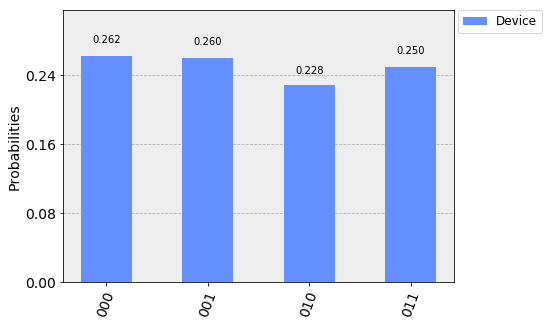

In [4]:
from qiskit.visualization import plot_histogram

result = job.result()
counts = result.get_counts(qc)

plot_histogram([counts], legend=['Device'])